<a href="https://colab.research.google.com/github/SamuelHericles/nuveo_challenge/blob/main/01-WheresWally/src/Test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports needed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import json
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Prepare our pre-trained faster rcnn model


In [ ]:
# If the model is not downloaded, we can do it here.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get number of input features for the classifier.
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2) # 1 class (wheat) + background

# Get weoghts and bias from our model pre-trained
model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/WheresWally/',
                                              "models", 'model.pt')))

# Switch model for tests
model.eval()

# 2. Model tests

This step is to upload an image from the dataset, test in the model, and get two points, max point and min point about wally photograph polygon, so with this, we can calculate the centroids in Test Set.

In [ ]:
# What image in dataset train you want to predict
image_number = 0 

In [ ]:
# Upload a image
imgs =  list(sorted(os.listdir('/content/drive/MyDrive/WheresWally/data/TrainingSet/images')))
img_path = os.path.join('/content/drive/MyDrive/WheresWally/data/TrainingSet', 
                         "images", imgs[image_number])

# Treate on with openCv and convert numpy type for after convert to torch.
img = np.array(cv2.imread(f'{img_path}', 1))
img_aux = img

# Transform image with torch tensor with float32 and after divide for
# the fasterrcnn_resnet50_fpn more clear to predict an output.
img = torch.tensor(img, dtype=torch.float32)
img /= 255.0

In [ ]:
# Upload a image
json_files = list(sorted(os.listdir('/content/drive/MyDrive/WheresWally/data/TrainingSet/json')))
points_path = os.path.join('/content/drive/MyDrive/WheresWally/data/TrainingSet', "json", json_files[image_number])        
json_uploaded = open(f'{points_path}','r')
json_file = json.loads(json_uploaded.read()) 

# Get polygon points of wally pothograph
points = json_file['shapes'][0]['points']

# 2.1 Predict a model with train dataset


In [ ]:
outputs = model(torch.reshape(img, (1, 3, img.size()[0], img.size()[1])))
print(outputs)

Expected ->  Max: [682, 467] --- Min: [432, 683]
Predicted -> Max: [424, 257] --- Min: [741, 475]


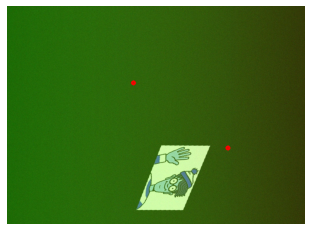

<Figure size 432x288 with 0 Axes>

In [ ]:
boxes = outputs[0]['boxes']
xmin, ymin, xmax, ymax = np.round(pd.DataFrame(boxes.detach().numpy()).mean().values)
xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

print(f'Expected ->  Max: {max(points)} --- Min: {min(points)}')
print(f'Predicted -> Max: {[xmin, ymin]} --- Min: {[xmax, ymax]}')

img_aux = cv2.circle(img_aux, (xmin, ymin), 5, (255, 0, 0), 5)
img_aux = cv2.circle(img_aux, (xmax, ymax), 5, (255, 0, 0), 5)

plt.axis('off')
plt.imshow(img_aux)
plt.show()   
plt.clf() 

# 3. Obtain centroids from TestSet folder

In [ ]:
predicts = []

for file_name in list(sorted(os.listdir('/content/drive/MyDrive/WheresWally/data/TestSet'))):

  # Get centroinds from test images
  img_path = os.path.join('/content/drive/MyDrive/WheresWally/data/TestSet', file_name)

  # Treate on with openCv and convert numpy type for after convert to torch.
  img = cv2.imread(f'{img_path}', 1)
  img = np.array(img)

  # Transform image with torch tensor with float32 and after divide for
  # the fasterrcnn_resnet50_fpn more clear to predict an output.
  img = torch.tensor(img, dtype=torch.float32)
  img /= 255.0

  # Predict model
  outputs = model(torch.reshape(img, (1, 3, img.size()[0], img.size()[1])))

  boxes = outputs[0]['boxes']
  xmin, ymin, xmax, ymax = np.round(pd.DataFrame(boxes.detach().numpy()).mean().values)
  xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

  centroid_x = int((xmin+xmax)/2)
  centroid_y = int((ymin+ymax)/2)

  predicts.append([file_name, centroid_x, centroid_y])

In [ ]:
pd.DataFrame(predicts, columns=['File_names','Centroid_x', 'Centroid_y']).to_csv('/content/drive/MyDrive/WheresWally/centroids_test.csv')